In [ ]:
from pandas import read_csv
import pandas as pd
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')

len(data)


10000

In [ ]:
data.value_counts(['Credit_Score'])

,count
Credit_Score,
Standard,5317
Poor,2900
Good,1783


In [ ]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Occupation                10000 non-null  object 
 3   Annual_Income             10000 non-null  float64
 4   Monthly_Inhand_Salary     10000 non-null  float64
 5   Num_Bank_Accounts         10000 non-null  int64  
 6   Num_Credit_Card           10000 non-null  int64  
 7   Interest_Rate             10000 non-null  float64
 8   Num_of_Loan               10000 non-null  int64  
 9   Type_of_Loan              10000 non-null  object 
 10  Delay_from_due_date       10000 non-null  float64
 11  Num_of_Delayed_Payment    10000 non-null  int64  
 12  Changed_Credit_Limit      10000 non-null  float64
 13  Num_Credit_Inquiries      10000 non-null  int64  
 14  Credit_

##LOGISTIC REGRESSION WITH BALANCING - ALL FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pandas as pd
from scipy.stats import uniform

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Identify numeric features (int and float types)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Standardize numeric features
scaler = StandardScaler()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Undersampling to match 'Poor' class size
undersample = RandomUnderSampler(sampling_strategy={'Standard': 2046}, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
print("After Undersampling:", Counter(y_train_resampled))

# Apply SMOTE to balance 'Good' class to the size of 'Poor'
smote = SMOTE(sampling_strategy={'Good': 2046}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)
print("After SMOTE:", Counter(y_train_resampled))

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.1, 10),  # Narrowed range for C
    'solver': ['lbfgs'],  # Using only 'lbfgs' solver
    'max_iter': [100, 200]  # Keep iterations smaller
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(LogisticRegression(multi_class='multinomial', random_state=42),
                                   param_distributions=param_dist, n_iter=5, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Logistic Regression with the best parameters
model = LogisticRegression(multi_class='multinomial', random_state=42, **best_params)
model.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation
y_pred = model.predict(X_test)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy, Recall, Precision, Specificity
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each class
def calculate_specificity(class_idx):
    # True Negatives for the current class
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    # False Positives for the current class
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    # Specificity = TN / (TN + FP)
    return tn / (tn + fp)

specificity_poor = calculate_specificity(0)  # Poor class (index 0)
specificity_standard = calculate_specificity(1)  # Standard class (index 1)
specificity_good = calculate_specificity(2)  # Good class (index 2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity for Poor: {specificity_poor:.4f}")
print(f"Specificity for Standard: {specificity_standard:.4f}")
print(f"Specificity for Good: {specificity_good:.4f}")

After Undersampling: Counter({'Poor': 2046, 'Standard': 2046, 'Good': 1231})
After SMOTE: Counter({'Good': 2046, 'Poor': 2046, 'Standard': 2046})


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Hyperparameters: {'C': np.float64(1.934347898661638), 'max_iter': 200, 'solver': 'lbfgs'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

        Poor       0.51      0.65      0.57       552
    Standard       0.61      0.69      0.65       854
        Good       0.75      0.63      0.68      1594

    accuracy                           0.65      3000
   macro avg       0.63      0.66      0.64      3000
weighted avg       0.67      0.65      0.65      3000

Confusion Matrix:
[[ 361   34  157]
 [  88  593  173]
 [ 255  339 1000]]
Accuracy: 0.6513
Recall: 0.6513
Precision: 0.6686
Specificity for Poor: 0.8599
Specificity for Standard: 0.8262
Specificity for Good: 0.7653


##LOGISTIC REGRESSION WITHOUT BALANCING - ALL FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pandas as pd
from scipy.stats import uniform

# Load data
data2 = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X2 = data2.drop(columns=['Credit_Score'])
y2 = data2['Credit_Score']

# Identify numeric features (int and float types)
numeric_features2 = X2.select_dtypes(include=['int64', 'float64']).columns

# Encode categorical features
X_encoded2 = pd.get_dummies(X2, drop_first=True)

# Standardize numeric features
scaler2 = StandardScaler()
X_encoded2[numeric_features2] = scaler2.fit_transform(X_encoded2[numeric_features2])

# Split into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_encoded2, y2, test_size=0.3, random_state=42)

# Define parameter distribution for RandomizedSearchCV
param_dist2 = {
    'C': uniform(0.1, 10),  # Narrowed range for C
    'solver': ['lbfgs'],  # Using only 'lbfgs' solver
    'max_iter': [100, 200]  # Keep iterations smaller
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search2 = RandomizedSearchCV(LogisticRegression(multi_class='multinomial', random_state=42),
                                    param_distributions=param_dist2, n_iter=5, cv=3,
                                    scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
random_search2.fit(X_train2, y_train2)

best_params2 = random_search2.best_params_
print(f"Best Hyperparameters: {best_params2}")

# Train Logistic Regression with the best parameters
model2 = LogisticRegression(multi_class='multinomial', random_state=42, **best_params2)
model2.fit(X_train2, y_train2)

# Predictions and Evaluation
y_pred2 = model2.predict(X_test2)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test2, y_pred2, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm2 = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(cm2)

# Accuracy, Recall, Precision, Specificity
accuracy2 = accuracy_score(y_test2, y_pred2)
recall2 = recall_score(y_test2, y_pred2, average='weighted')
precision2 = precision_score(y_test2, y_pred2, average='weighted')

# Calculate Specificity for each class
def calculate_specificity2(class_idx2):
    # True Negatives for the current class
    tn2 = cm2.sum() - cm2[:, class_idx2].sum() - cm2[class_idx2, :].sum() + cm2[class_idx2, class_idx2]
    # False Positives for the current class
    fp2 = cm2[:, class_idx2].sum() - cm2[class_idx2, class_idx2]
    # Specificity = TN / (TN + FP)
    return tn2 / (tn2 + fp2)

specificity_poor2 = calculate_specificity2(0)  # Poor class (index 0)
specificity_standard2 = calculate_specificity2(1)  # Standard class (index 1)
specificity_good2 = calculate_specificity2(2)  # Good class (index 2)

print(f"Accuracy: {accuracy2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Specificity for Poor: {specificity_poor2:.4f}")
print(f"Specificity for Standard: {specificity_standard2:.4f}")
print(f"Specificity for Good: {specificity_good2:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Hyperparameters: {'C': np.float64(1.934347898661638), 'max_iter': 200, 'solver': 'lbfgs'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

        Poor       0.57      0.50      0.53       552
    Standard       0.67      0.56      0.61       854
        Good       0.67      0.75      0.71      1594

    accuracy                           0.65      3000
   macro avg       0.63      0.61      0.62      3000
weighted avg       0.65      0.65      0.65      3000

Confusion Matrix:
[[ 278   16  258]
 [  41  480  333]
 [ 171  225 1198]]
Accuracy: 0.6520
Recall: 0.6520
Precision: 0.6497
Specificity for Poor: 0.9134
Specificity for Standard: 0.8877
Specificity for Good: 0.5797


##LOGISTIC REGRESSION WITH BALANCING - SELECTED FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pandas as pd
from scipy.stats import uniform
import numpy as np

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X3 = data.drop(columns=['Credit_Score'])
y3 = data['Credit_Score']

# Identify numeric features (int and float types)
numeric_features3 = X3.select_dtypes(include=['int64', 'float64']).columns

# Encode categorical features
X_encoded3 = pd.get_dummies(X3, drop_first=True)

# Standardize numeric features
scaler3 = StandardScaler()
X_encoded3[numeric_features3] = scaler3.fit_transform(X_encoded3[numeric_features3])

# Split into train and test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_encoded3, y3, test_size=0.3, random_state=42)

# Undersampling to match 'Poor' class size
undersample3 = RandomUnderSampler(sampling_strategy={'Standard': 2046}, random_state=42)
X_train_resampled3, y_train_resampled3 = undersample3.fit_resample(X_train3, y_train3)
print("After Undersampling:", Counter(y_train_resampled3))

# Apply SMOTE to balance 'Good' class to the size of 'Poor'
smote3 = SMOTE(sampling_strategy={'Good': 2046}, random_state=42)
X_train_resampled3, y_train_resampled3 = smote3.fit_resample(X_train_resampled3, y_train_resampled3)
print("After SMOTE:", Counter(y_train_resampled3))

# Quick feature selection using feature importance
base_model3 = RandomForestClassifier(n_estimators=50, random_state=42)
base_model3.fit(X_train_resampled3, y_train_resampled3)
feature_importances3 = base_model3.feature_importances_
top_features_idx3 = np.argsort(feature_importances3)[-10:]
top_10_features3 = X_train_resampled3.columns[top_features_idx3]
print(f"Top 10 Features: {list(top_10_features3)}")

# Subset data with selected features
X_train_selected3 = X_train_resampled3[top_10_features3]
X_test_selected3 = X_test3[top_10_features3]

# Define parameter distribution for RandomizedSearchCV
param_dist3 = {
    'C': uniform(0.1, 10),
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search3 = RandomizedSearchCV(LogisticRegression(multi_class='multinomial', random_state=42),
                                    param_distributions=param_dist3, n_iter=5, cv=3,
                                    scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
random_search3.fit(X_train_selected3, y_train_resampled3)

best_params3 = random_search3.best_params_
print(f"Best Hyperparameters: {best_params3}")

# Train Logistic Regression with the best parameters
model3 = LogisticRegression(multi_class='multinomial', random_state=42, **best_params3)
model3.fit(X_train_selected3, y_train_resampled3)

# Predictions and Evaluation
y_pred3 = model3.predict(X_test_selected3)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test3, y_pred3, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm3 = confusion_matrix(y_test3, y_pred3)
print("Confusion Matrix:")
print(cm3)

# Accuracy, Recall, Precision, Specificity
accuracy3 = accuracy_score(y_test3, y_pred3)
recall3 = recall_score(y_test3, y_pred3, average='weighted')
precision3 = precision_score(y_test3, y_pred3, average='weighted')

# Calculate Specificity for each class
def calculate_specificity(class_idx):
    tn = cm3.sum() - cm3[:, class_idx].sum() - cm3[class_idx, :].sum() + cm3[class_idx, class_idx]
    fp = cm3[:, class_idx].sum() - cm3[class_idx, class_idx]
    return tn / (tn + fp)

specificity_poor3 = calculate_specificity(0)
specificity_standard3 = calculate_specificity(1)
specificity_good3 = calculate_specificity(2)

print(f"Accuracy: {accuracy3:.4f}")
print(f"Recall: {recall3:.4f}")
print(f"Precision: {precision3:.4f}")
print(f"Specificity for Poor: {specificity_poor3:.4f}")
print(f"Specificity for Standard: {specificity_standard3:.4f}")
print(f"Specificity for Good: {specificity_good3:.4f}")



After Undersampling: Counter({'Poor': 2046, 'Standard': 2046, 'Good': 1231})
After SMOTE: Counter({'Good': 2046, 'Poor': 2046, 'Standard': 2046})
Top 10 Features: ['Annual_Income', 'Age', 'Num_of_Delayed_Payment', 'Num_Credit_Card', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Num_Bank_Accounts', 'Delay_from_due_date', 'Interest_Rate', 'Outstanding_Debt']
Best Hyperparameters: {'C': np.float64(3.845401188473625), 'max_iter': 100, 'solver': 'lbfgs'}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.42      0.74      0.53       552
    Standard       0.60      0.66      0.63       854
        Good       0.75      0.51      0.60      1594

    accuracy                           0.59      3000
   macro avg       0.59      0.64      0.59      3000
weighted avg       0.64      0.59      0.60      3000

Confusion Matrix:
[[408  23 121]
 [134 567 153]
 [435 352 807]]
Accuracy: 0.5940
Recall: 0.5940
Precision: 0.6448
Specificity for Poor: 0.7

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


##LOGISTIC REGRESSION WITHOUT BALANCING - S FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.stats import uniform
import numpy as np

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X4 = data.drop(columns=['Credit_Score'])
y4 = data['Credit_Score']

# Identify numeric features (int and float types)
numeric_features4 = X4.select_dtypes(include=['int64', 'float64']).columns

# Encode categorical features
X_encoded4 = pd.get_dummies(X4, drop_first=True)

# Standardize numeric features
scaler4 = StandardScaler()
X_encoded4[numeric_features4] = scaler4.fit_transform(X_encoded4[numeric_features4])

# Split into train and test
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_encoded4, y4, test_size=0.3, random_state=42)

# Quick feature selection using feature importance
base_model4 = RandomForestClassifier(n_estimators=50, random_state=42)
base_model4.fit(X_train4, y_train4)
feature_importances4 = base_model4.feature_importances_
top_features_idx4 = np.argsort(feature_importances4)[-10:]
top_10_features4 = X_train4.columns[top_features_idx4]
print(f"Top 10 Features: {list(top_10_features4)}")

# Subset data with selected features
X_train_selected4 = X_train4[top_10_features4]
X_test_selected4 = X_test4[top_10_features4]

# Define parameter distribution for RandomizedSearchCV
param_dist4 = {
    'C': uniform(0.1, 10),
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}

# Perform RandomizedSearchCV for hyperparameter tuning
random_search4 = RandomizedSearchCV(LogisticRegression(multi_class='multinomial', random_state=42),
                                    param_distributions=param_dist4, n_iter=5, cv=3,
                                    scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
random_search4.fit(X_train_selected4, y_train4)

best_params4 = random_search4.best_params_
print(f"Best Hyperparameters: {best_params4}")

# Train Logistic Regression with the best parameters
model4 = LogisticRegression(multi_class='multinomial', random_state=42, **best_params4)
model4.fit(X_train_selected4, y_train4)

# Predictions and Evaluation
y_pred4 = model4.predict(X_test_selected4)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test4, y_pred4, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm4 = confusion_matrix(y_test4, y_pred4)
print("Confusion Matrix:")
print(cm4)

# Accuracy, Recall, Precision, Specificity
accuracy4 = accuracy_score(y_test4, y_pred4)
recall4 = recall_score(y_test4, y_pred4, average='weighted')
precision4 = precision_score(y_test4, y_pred4, average='weighted')

# Calculate Specificity for each class
def calculate_specificity(class_idx):
    tn = cm4.sum() - cm4[:, class_idx].sum() - cm4[class_idx, :].sum() + cm4[class_idx, class_idx]
    fp = cm4[:, class_idx].sum() - cm4[class_idx, class_idx]
    return tn / (tn + fp)

specificity_poor4 = calculate_specificity(0)
specificity_standard4 = calculate_specificity(1)
specificity_good4 = calculate_specificity(2)

print(f"Accuracy: {accuracy4:.4f}")
print(f"Recall: {recall4:.4f}")
print(f"Precision: {precision4:.4f}")
print(f"Specificity for Poor: {specificity_poor4:.4f}")
print(f"Specificity for Standard: {specificity_standard4:.4f}")
print(f"Specificity for Good: {specificity_good4:.4f}")


Top 10 Features: ['Monthly_Inhand_Salary', 'Annual_Income', 'Monthly_Balance', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Card', 'Num_Credit_Inquiries', 'Delay_from_due_date', 'Interest_Rate', 'Outstanding_Debt']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Hyperparameters: {'C': np.float64(3.845401188473625), 'max_iter': 100, 'solver': 'lbfgs'}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.61      0.40      0.48       552
    Standard       0.66      0.51      0.57       854
        Good       0.64      0.79      0.71      1594

    accuracy                           0.64      3000
   macro avg       0.63      0.57      0.59      3000
weighted avg       0.64      0.64      0.63      3000

Confusion Matrix:
[[ 221    9  322]
 [  26  435  393]
 [ 117  218 1259]]
Accuracy: 0.6383
Recall: 0.6383
Precision: 0.6376
Specificity for Poor: 0.9416
Specificity for Standard: 0.8942
Specificity for Good: 0.4915


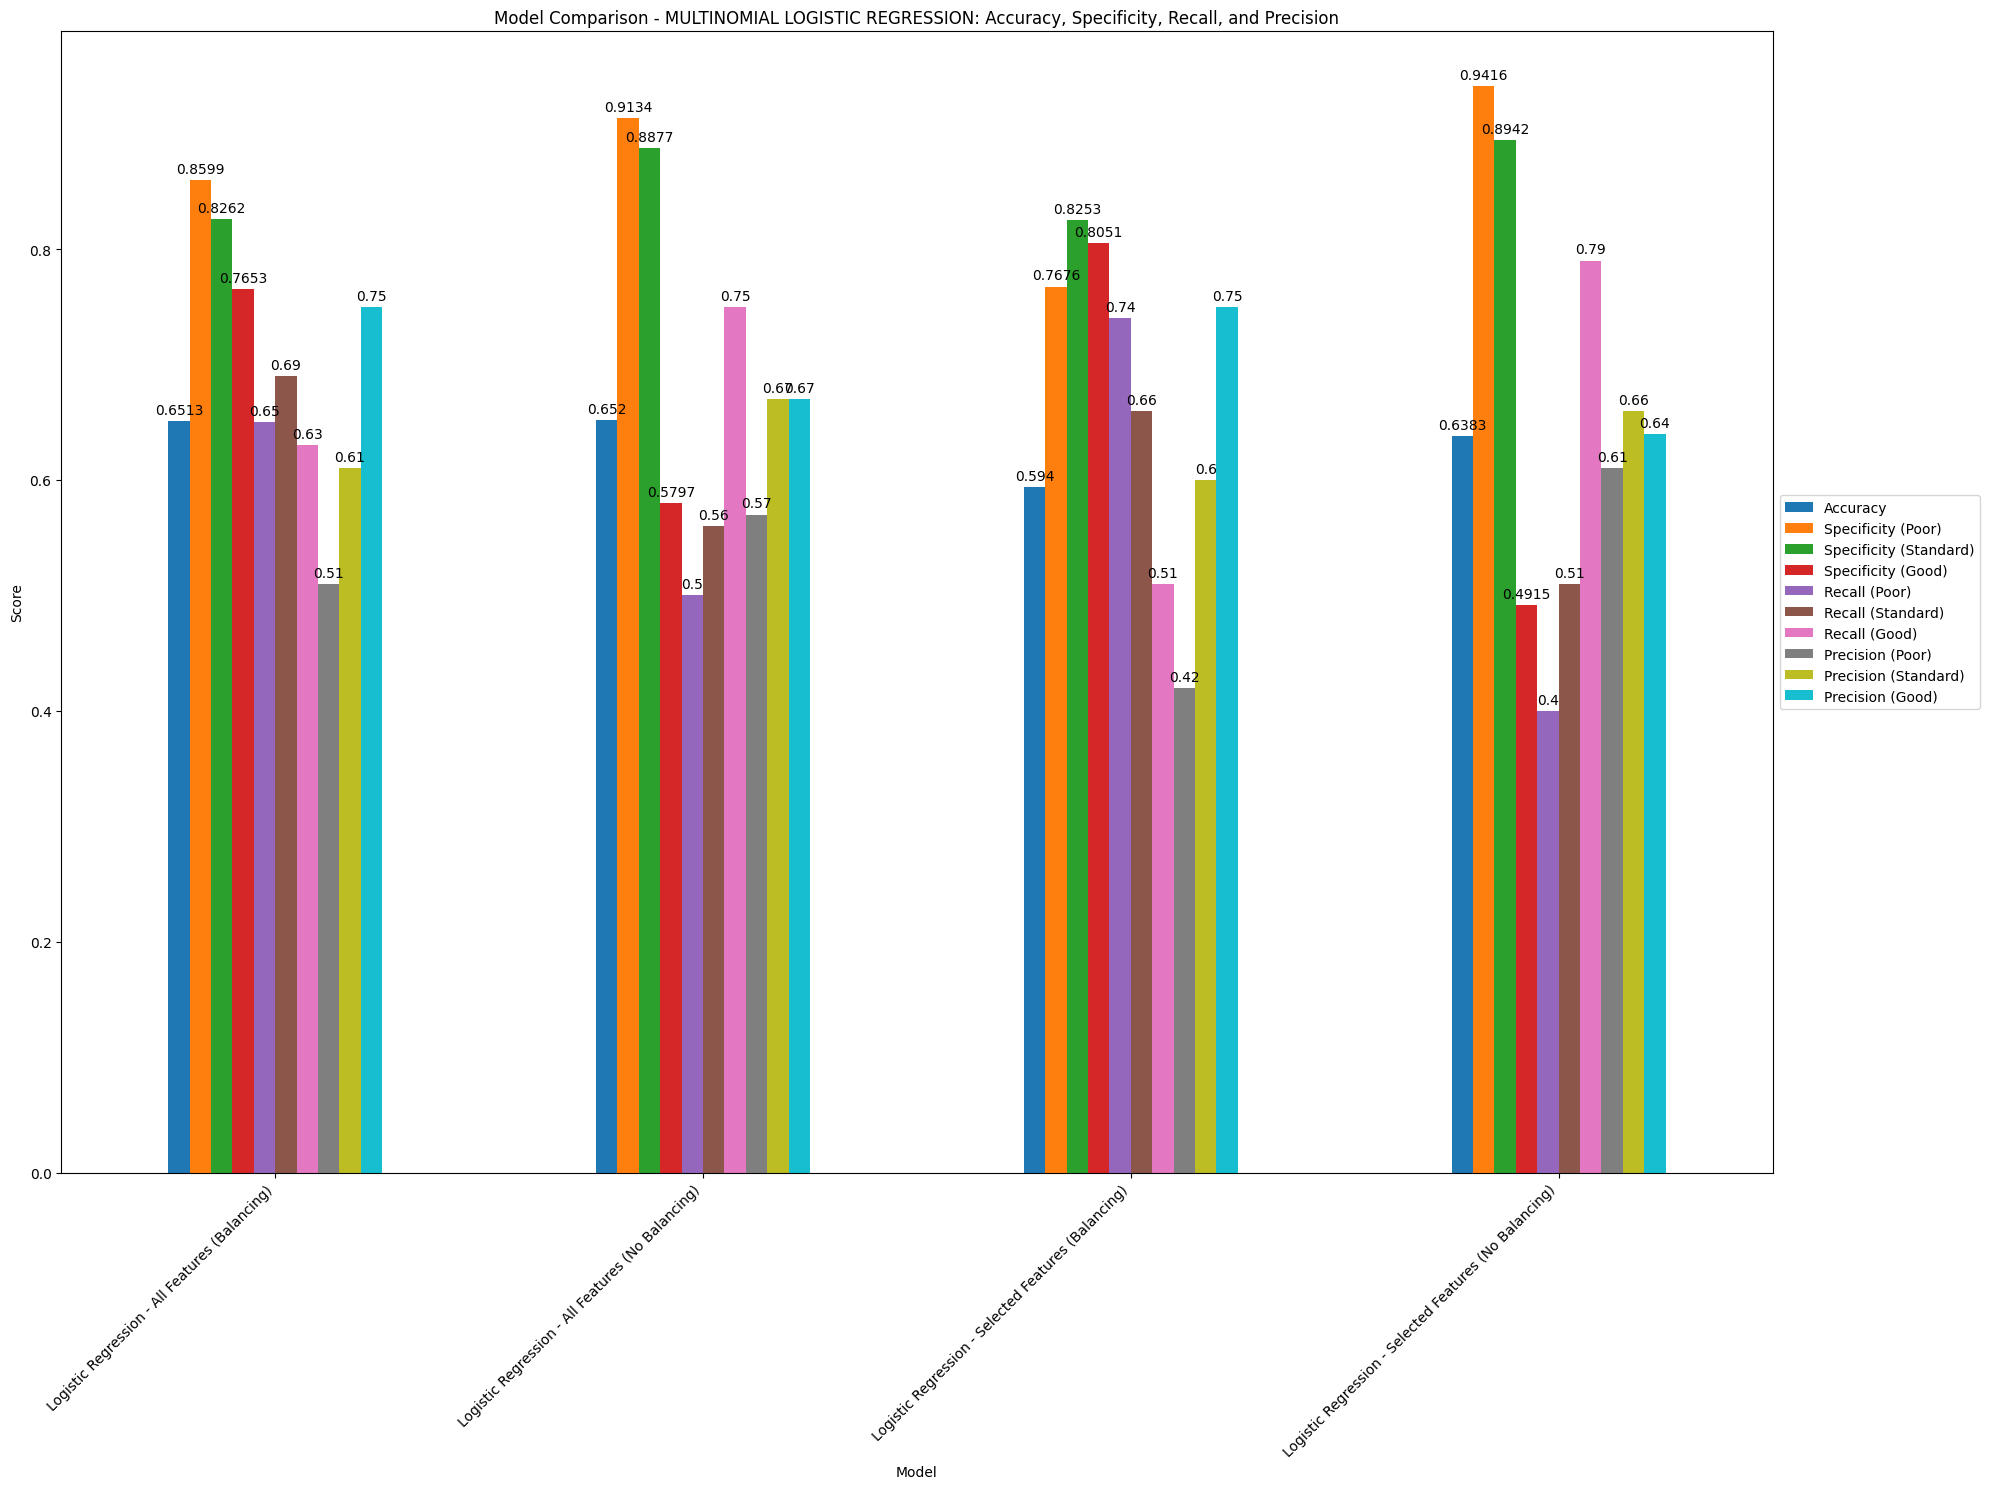

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Updated Comparison Data for Accuracy, Specificity, Recall, and Precision
accuracy_specificity_data = {
    'Model': ['Logistic Regression - All Features (Balancing)', 'Logistic Regression - All Features (No Balancing)',
              'Logistic Regression - Selected Features (Balancing)', 'Logistic Regression - Selected Features (No Balancing)'],
    'Accuracy': [0.6513, 0.6520, 0.5940, 0.6383],
    'Specificity (Poor)': [0.8599, 0.9134, 0.7676, 0.9416],
    'Specificity (Standard)': [0.8262, 0.8877, 0.8253, 0.8942],
    'Specificity (Good)': [0.7653, 0.5797, 0.8051, 0.4915],
    'Recall (Poor)': [0.65, 0.50, 0.74, 0.40],
    'Recall (Standard)': [0.69, 0.56, 0.66, 0.51],
    'Recall (Good)': [0.63, 0.75, 0.51, 0.79],
    'Precision (Poor)': [0.51, 0.57, 0.42, 0.61],
    'Precision (Standard)': [0.61, 0.67, 0.60, 0.66],
    'Precision (Good)': [0.75, 0.67, 0.75, 0.64]
}

# Create DataFrame for plotting
metrics_df = pd.DataFrame(accuracy_specificity_data)

# Plot the comparison for Accuracy, Specificity, Recall, and Precision
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(20, 15))

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

# Title and labels
plt.title('Model Comparison - MULTINOMIAL LOGISTIC REGRESSION: Accuracy, Specificity, Recall, and Precision')
plt.ylabel('Score')
plt.xlabel('Model')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()
